In [1]:
!pwd

/home/bizon/Research/BLAP


In [53]:


all_levels = ['./processed/Castlevania_185.txt']
all_levels = !ls ./processed/*Mario*
path_vocab = {'S':'Ś', 'E':'Ě', '-':'+', 'e':'ě', 'X':'Ǩ', '*':'★', 
              '|':'¦', '^':'⌅', 'v':'ѷ', '$':'§', 'o':'©'}

start_vocab = {'S':'∫', 'E':'∃', '-':'∓', 'e':'∈', 'X':'∑', '*':'⋇', 
              '|':'≬', '^':'⊤', 'v':'⋎', '$':'∲', 'o':'∘'}

end_vocab = {'S':'√', 'E':'∄', '-':'∔', 'e':'∉', 'X':'∏', '*':'⊛', 
              '|':'∥', '^':'⊥', 'v':'⊻', '$':'∱', 'o':'⊜'}
is_start = set(start_vocab.values())
is_end = set(end_vocab.values())
is_path = set(path_vocab.values()) | is_start | is_end

solid  = set(['S','|','Q','@','^','#','X','!','E'])
to_add = []
for s in solid:
    to_add.append(start_vocab.get(s,s))
    to_add.append(end_vocab.get(s,s))

solid |= set(to_add)

print(solid)

{'∑', '∫', 'E', '∃', 'Q', '√', '≬', '⊥', '!', 'X', 'S', '⊤', '∥', '∄', '^', '#', '∏', '@', '|'}


In [54]:

jumps = []
falls = []


for filename in all_levels:
    level = []
    with open(filename) as infile:
        for line in infile:
            level.append(line.rstrip())
    level_ = list(reversed(level))
    width = len(level[0])
    height = len(level)
    path_locations = []
    start = None
    end = None
    leftest = None
    rightest = None
    for yy in range(height):
        for xx in range(width):
            if level[yy][xx] in is_path:
                if not leftest:
                    leftest = (xx,yy)
                rightest = (xx,yy)
                path_locations.append((xx,yy))
                if level[yy][xx] in is_start:
                    start = (xx,yy)
                elif level[yy][xx] in is_end:
                    end = (xx,yy)
    if not start and not end:
        print('UH OH', filename)
        continue
    x_pos = list(range(width))
    prev_y = leftest[1]
    
    if start:
        start = (start[0],height-start[1]-1)
        if start[0] >= 16:
            print(filename, 'S', start)
            x_pos = list(reversed(x_pos))
            prev_y = rightest[1]
            if not end:
                end = (leftest[0],height-leftest[1]-1)
        elif not end:
            end = (rightest[0],height-rightest[1]-1)
    elif end[0] < 16:
            print(filename, 'E', end)
            x_pos = list(reversed(x_pos))
            prev_y = rightest[1]
            if not start:
                end = (leftest[0],height-leftest[1]-1)
    
    if not start:
        start = (leftest[0],height-leftest[1]-1) 
        
    prev_y = start[1]
    prev_on_ground = True
    path_snippets = []
    last_location = start
    
    x_prev = start[0]
    
    for x in x_pos:
        player_locations = []

        for y in range(height):
            if level_[y][x] in is_path:
                player_locations.append((x,y))
                last_location = player_locations[-1]
        current_y = last_location[1]
        current_on_ground = level_[current_y-1][x] in solid
        if len(player_locations) == 0:
            continue
            
        if len(player_locations) > 1 and start[0] != x:
            if prev_on_ground and not current_on_ground:
                path_snippets.append((x_prev,prev_y))
            path_snippets += player_locations
            prev_y = current_y
            prev_on_ground = current_on_ground
        elif current_on_ground and not prev_on_ground:
            path_snippets.append((x,current_y))
        elif prev_on_ground and not current_on_ground:
            path_snippets.append((x_prev,prev_y))
            path_snippets.append((x,current_y))
        elif not prev_on_ground and not current_on_ground:
            path_snippets.append((x,current_y))
        prev_y = current_y
        x_prev = x
        prev_on_ground = current_on_ground
    px = -100
    py = -100
    falling = False
    snippet = []
    snippets = []
    
    for p in path_snippets:
            
        if p[0] - px > 1:
            if snippet:
                snippets.append(snippet)
            snippet = []
            falling = False
            
        
        if falling and p[1] > py:
            #print('B')
            if snippet:
                snippets.append(snippet)
            snippet = []
            falling = False


        if level_[p[1]-1][p[0]] in solid:
            #print('C')
            if snippet:
                snippets.append(snippet)
            snippet = []
            falling = False
        
        if snippet and p[1] < py:            
            falling = True
            
        if len(snippet) == 0 or (len(snippet) > 0 and snippet[-1] != p):
            snippet.append(p)
        #print('snippet',snippet)
        px = p[0]
        py = p[1]
    snippets = [snippet for snippet in snippets if len(set(snippet))>1]
    merged_snippets = []
    merge_with_next = []
    
    for snippet in snippets:
        if len(snippet) == 1:
            if len(merged_snippets) > 0:
                if abs(snippet[0][0] - merged_snippets[-1][-1][0]) <= 1:
                    merged_snippets[-1] += snippet
            merge_with_next = snippet
        else:
            merged_snippets.append(snippet )
            merge_with_next = []
    py = -100
    for snippet in merged_snippets:
        dy = 0
        prev = snippet[0]
        falling = False
        jump = []
        fall = []
        py = -100
        for pt in snippet:
            if pt[1] < py:
                falling = True
                fall.append(prev)
            if falling:
                fall.append(pt)
            else:
                jump.append(pt)
            py = pt[1]
            prev = pt
        jy = jump[0][1]
        allSame = True
        for pt in jump:
            allSame = allSame and jy == pt[1]
        if not allSame:
            jumps.append(jump)
            
            path = np.array(jump)
            path[:,1] -= path[0,1]
            if np.max(path[:,1]) > 5:
                print('\n'.join(level))
        falls.append(fall)
    

--------------------------------
--------------------------------
---------------------------++++-
--------------------------++---∄
-------------------------++---XX
-------------------------++---XX
-------------!-----------S+---XX
-----------------------++++-----
-------------+++++----++--+-----
----------+++©----+--++---S-----
--------++Ě--S-----+++----------
-------++XX---------+-----------
------++-XX---X----XX-----------
∃Ě+++++--XXE--X----XX---E-------
XXXXXXXXXXXXXXX----XXXXXXXXX----
--------------------------------
--------------------------------
--------------------------++++--
-------------------------++---Ě∔
------------------------++---XX-
------------------------++---XX-
------------!-----------S+---XX-
----------------------++++------
------------+++++----++--+------
---------+++©----+--++---S------
-------++Ě--S-----+++-----------
------++XX---------+------------
-----++-XX---X----XX------------
∃+++++--XXE--X----XX---E--------
XXXXXXXXXXXXXX----XXXXXXXXX-----
----------

In [55]:
jumps = [j for j in jumps if len(j) > 2]
falls = [j for j in falls if len(j) > 2]
print(len(jumps))


11790


In [56]:
if len(jumps) < 500:
    import matplotlib.pyplot as plt
    import numpy as np

    for snippet in jumps:
        path = np.array(snippet)
        path[:,0] -= path[0,0]
        path[:,1] -= path[0,1]
        plt.plot(path[:,0],path[:,1])
    plt.show()

    keep = []
    for snippet in falls:
        path = np.array(snippet)
        path[:,0] -= path[0,0]
        path[:,1] -= path[0,1]
        if (path[:,1] > 0).any():
            pass
        else:
            keep.append(snippet)
            plt.plot(path[:,0],path[:,1])
    plt.show()
    falls = keep

In [57]:
import statsmodels.api as sm

{0: 0.0, 1: -2.0, 2: -3.0, 3: -4.0, 4: -5.0, 5: -6.0, 6: -6.0, 7: -7.0, 8: -8.0, 9: -9.0}
[ 1.60043237 -0.1586257 ] [ 413.08050158 -138.18540438]


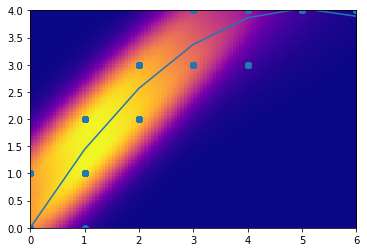

[-0.32873964] [-45.98637326]


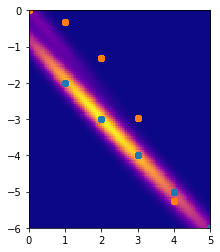

In [166]:
import random
from scipy import stats

jump_data = []
for snippet in jumps:
    path = np.array(snippet)
    path[:,0] -= path[0,0]
    path[:,1] -= path[0,1]
    jump_data.append(path)
    


fall_data = []
for snippet in falls:
    path = np.array(snippet)
    path[:,0] -= path[0,0]
    path[:,1] -= path[0,1]
    fall_data.append(path)
    
truncate = 0.0
by_point = {}
if truncate != 1.0:
    maximal_by_x = {}
    for jump in jump_data:
        seen = set()
        for point in jump:
            if not point[0] in by_point:
                by_point[point[0]] = []
            by_point[point[0]].append(point[1])
            my = maximal_by_x.get(point[0],-float('inf'))
            
            if point[1] > my and not point[0] in seen:
                maximal_by_x[point[0]] = point[1]
            seen.add(point[0])
               
    jump_data_ = []            
    for x in by_point:
        median_y = np.quantile(by_point[x],0.75)
        by_point[x] = median_y
        
    for jump in jump_data:
        good_jump = {}
        for point in jump:
            if point[0] not in good_jump:                
                good_jump[point[0]] = False
                
            if point[1] == by_point[point[0]]:
                good_jump[point[0]] = True
            if point[1] > by_point[point[0]]:
                good_jump[point[0]] = False
        
        num_good = 0
        for x in good_jump:
            if good_jump[x]:
                num_good += 1
        if   num_good/len(good_jump) > 0.5 or random.random() < truncate:
            jump_data_.append(jump)
    
    jump_data = jump_data_           
             
    by_point = {}    
    for fall in fall_data:
        seen = set()
        for point in fall:
            if not point[0] in by_point:
                by_point[point[0]] = []
            by_point[point[0]].append(point[1])
            seen.add(point[0])
    fall_data_ = []            
    for x in by_point:
        median_y = np.quantile(by_point[x],0.01)
        by_point[x] = median_y
    print(by_point)
        
    for fall in fall_data:
        good_fall = {}
        for point in fall:
            if point[0] not in good_fall:                
                good_fall[point[0]] = False
                
            if point[1] == by_point[point[0]]:
                good_fall[point[0]] = True
            if point[1] > by_point[point[0]]:
                good_fall[point[0]] = False
        
        num_good = 0
        for x in good_fall:
            if good_fall[x]:
                num_good += 1
        if   num_good/len(good_fall) > 0.5 or random.random() < truncate:
            fall_data_.append(fall)
    
    fall_data = fall_data_
jump_data = np.vstack(jump_data)
fall_data = np.vstack(fall_data)

from scipy import stats
jump_X = np.hstack([jump_data[:,0].reshape([-1,1]),jump_data[:,0].reshape([-1,1])**2])
jump_Y = jump_data[:,1].reshape([-1,1])

jump_model = sm.OLS(jump_Y,jump_X)
jump_results = jump_model.fit()
print(jump_results.params,jump_results.tvalues)
xmin  = np.min(jump_X[:,0])
xmax  = np.max(jump_X[:,0])
ymin  = np.min(jump_Y[:,0])
ymax  = np.max(jump_Y[:,0])

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([jump_X[:,0],jump_Y[:,0]])
kernel = stats.gaussian_kde(values,bw_method=0.85)
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.plasma,
          extent=[xmin, xmax, ymin, ymax])

x = np.array(list(range(xmin,xmax+1)))
x = np.vstack([x,x**2]).T
y_hat = np.dot(x,jump_results.params)
plt.scatter(jump_X[:,0],jump_Y[:,0])
plt.plot(x[:,0],y_hat)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

fall_X = fall_data[:,0].reshape([-1,1])**2
fall_Y = fall_data[:,1].reshape([-1,1])

fall_model = sm.OLS(fall_Y,fall_X)
fall_results = fall_model.fit()
print(fall_results.params,fall_results.tvalues)
xmin  = np.min(fall_X[:,0])
xmax  = np.max(fall_X[:,0]**0.5)
ymin  = np.min(fall_Y[:,0])
ymax  = np.max(fall_Y[:,0])

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([fall_X[:,0]**0.5,fall_Y[:,0]])
kernel = stats.gaussian_kde(values,bw_method=0.85)
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.plasma,
          extent=[xmin, xmax, ymin, ymax])
plt.scatter(fall_data[:,0],fall_Y[:,0])
plt.scatter(fall_data[:,0],np.dot(fall_X,fall_results.params))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
0
1
1
4
0
1
1
4
0
1
1
4
4
9
9
16
16
25
25
36
0
1
1
4
4
9
9
16
16
25
25
36
0
1
1
4
4
9
9
16
16
25
25
36
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
0
1
1
4
0
1
1
4
4
9
9
16
16
25
25
36
0
1
1
4
0
1
1
4
4
9
9
16
16
25
25
36
0
1
1
4
0
1
1
4
4
9
9
16
0
1
1
4
4
9
9
16
0
1
1
4
4
9
9
16
0
1
1
4
4
9
9
16
16
25
0
1
1
4
4
9
9
16
16
25
0
1
1
4
4
9
0
1
1
4
4
9
9
16
16
25
0
1
1
4
4
9
9
16
16
25
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
0
1
1
4
4
9
9
16
0
1
1
4
4
9
9
16
0
1
1
4
0
1
1
4
0
1
1
4
0
1
1
4
4
9
0
1
1
4
4
9
9
16
0
1
1
4
4
9
9
16
0
1
1
4
4
9
9
16
16
25
25
36
36
49
0
1
1
4
4
9
9
16
16
25
25
36
36
49
0
1
1
4
4
9
9
16
16
25
25
36
36
49
0
1
4
0
1
4
0
1
4
0
1
1
4
0
1
1
4
0
1
1
4
0
1
4
0
1

In [62]:
[ 1.52484667 -0.13711021] [ 55.78654899 -14.26547203]

[-0.13124125] [-104.18771382]



TypeError: list indices must be integers or slices, not float